### Import

In [1]:
import os.path as osp
import os
import cv2
import numpy as np
# from transform import *
from PIL import Image
import matplotlib.pyplot as plt


### Preprocessing

In [2]:
face_data = '/home/hsu/HD/dataset/CelebAMask-HQ/CelebA-HQ-img'
face_sep_mask = '/home/hsu/HD/dataset/CelebAMask-HQ/CelebAMask-HQ-mask-anno'
mask_path = '/home/hsu/HD/dataset/CelebAMask-HQ/mask'

if not os.path.exists(mask_path):
    os.makedirs(mask_path)

In [3]:

# counter = 0
# total = 0

# # for i in range(15):
# for i in range(1):

#     atts = ['skin', 'l_brow', 'r_brow', 'l_eye', 'r_eye', 'eye_g', 'l_ear', 'r_ear', 'ear_r',
#             'nose', 'mouth', 'u_lip', 'l_lip', 'neck', 'neck_l', 'cloth', 'hair', 'hat']

#     for j in range(i * 2000, (i + 1) * 2000):

#         mask = np.zeros((512, 512))

#         # index starts from 1
#         for l, att in enumerate(atts, 1):
#             total += 1
#             file_name = ''.join([str(j).rjust(5, '0'), '_', att, '.png'])
#             print(file_name)
#             path = osp.join(face_sep_mask, str(i), file_name)
#             print(path)

#             if os.path.exists(path):
#                 counter += 1
#                 sep_mask = np.array(Image.open(path).convert('P'))
#                 # print(np.unique(sep_mask))
#                 # plt.imshow(sep_mask)
#                 # plt.show()
#                 mask[sep_mask == 225] = l
#         # print(np.unique(mask))
#         cv2.imwrite('{}/{}.png'.format(mask_path, j), mask)
#         plt.imshow(mask)
#         plt.show()

#         print(j)
#         break

# print(counter, total)

### Augmentation.py

### Dataset

In [4]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms

import os.path as osp
import os
from PIL import Image
import numpy as np
import json
import cv2
from augmentation import *
import augmentation as aug

class CelebAMask_HQ_Dataset(Dataset):
    def __init__(self, 
                 root_dir,
                 sample_indices, 
                 mode,
                 tr_transform=None):

        assert mode in ('train', "val", "test")

        self.root_dir = root_dir
        self.mode = mode

        self.tr_transform = tr_transform
        self.to_tensor = transforms.Compose([
            transforms.ToTensor(),
            # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])

        self.image_dir = os.path.join(root_dir, 'CelebA-HQ-img')  # Path to image folder
        self.mask_dir = os.path.join(root_dir, 'mask')    # Path to mask folder
        self.sample_indices = sample_indices

        # self.images = os.listdir(self.image_dir)
        # self.masks = os.listdir(self.mask_dir)
        
        self.train_dataset = []
        self.test_dataset = []
        self.preprocess()
        
        # if train_mode:
        #     self.num_images = len(self.train_dataset)
        # else:
        #     self.num_images = len(self.test_dataset)
        
        

    def preprocess(self):
        for i in range(len([name for name in os.listdir(self.image_dir) if osp.isfile(osp.join(self.image_dir, name))])):
            img_path = osp.join(self.image_dir, str(i)+'.jpg')
            label_path = osp.join(self.mask_dir, str(i)+'.png')

            if self.mode != "test":
                self.train_dataset.append([img_path, label_path])
            else:
                self.test_dataset.append([img_path, label_path])

    def __getitem__(self, idx):
        idx = self.sample_indices[idx]
        
        if self.mode != "test":
            img_pth, mask_pth = self.train_dataset[idx]
        else:
            img_pth, mask_pth = self.test_dataset[idx]
        
        

        # read img, mask
        image = Image.open(img_pth).convert('RGB')
        image = image.resize((512, 512), Image.BILINEAR)
        # mask = Image.open(mask_pth).convert('P')
        mask = Image.open(mask_pth).convert('L')
        
        # mask = Image.open(mask_pth).convert('L')

        # data augmentation
        if self.mode == 'train':
            image, mask = self.tr_transform(image, mask)
            # mask = self.tr_transform(mask)

        image = self.to_tensor(image)
        mask = torch.from_numpy(np.array(mask)).long()
        # mask = np.array(mask).astype(np.int64)[np.newaxis, :]
        # mask = transforms.ToTensor()(mask)
        
        
        return image, mask


    def __len__(self):
        return len(self.sample_indices)


### Transforms

In [5]:
train_tranform = aug.Compose({
    RandomCrop(448),
    RandomHorizontallyFlip(p=0.5),
    AdjustBrightness(bf=0.1),
    AdjustContrast(cf=0.1),
    AdjustHue(hue=0.1),
    AdjustSaturation(saturation=0.1)
})
# transform = Compose([RandomHorizontallyFlip(p=.5), RandomSized(size=config.imsize), \
#             AdjustBrightness(bf=0.1), AdjustContrast(cf=0.1), AdjustHue(hue=0.1), \
#             AdjustSaturation(saturation=0.1)])

### Train/Val/Test Split

In [6]:
from sklearn.model_selection import train_test_split

root_dir = "/home/hsu/HD/dataset/CelebAMask-HQ"
image_dir = os.path.join(root_dir, 'CelebA-HQ-img')

train_indices = set()
indices_file_pth = os.path.join(root_dir, 'train.txt')
with open(indices_file_pth, 'r') as file:
    train_indices = set(map(int, file.read().splitlines()))
    
sample_indices = list(range(len(os.listdir(image_dir))))
test_indices = [idx for idx in sample_indices if idx not in train_indices]
# Split indices into training and validation sets
train_indices = list(train_indices)
# train_indices = train_indices[:100]         ############################################################################################################
train_indices, valid_indices = train_test_split(train_indices, test_size=0.15, random_state=1187)
print(len(train_indices))
print(len(valid_indices))
print(len(test_indices))
print(test_indices)


20400
3600
6000
[4, 13, 20, 34, 35, 61, 62, 65, 68, 75, 86, 89, 98, 110, 111, 113, 122, 133, 134, 148, 152, 154, 163, 164, 166, 171, 176, 178, 186, 188, 197, 199, 201, 202, 203, 209, 212, 215, 219, 221, 228, 238, 240, 242, 249, 251, 256, 261, 265, 276, 287, 292, 295, 306, 310, 324, 326, 344, 351, 355, 357, 358, 367, 372, 382, 385, 396, 400, 404, 413, 419, 422, 440, 445, 452, 455, 472, 478, 490, 497, 500, 502, 505, 525, 527, 536, 537, 540, 541, 546, 548, 553, 559, 562, 564, 571, 575, 579, 582, 586, 588, 589, 590, 594, 598, 599, 600, 608, 609, 612, 613, 617, 618, 625, 629, 635, 642, 648, 650, 658, 664, 672, 678, 679, 686, 691, 706, 711, 713, 716, 717, 718, 721, 726, 731, 739, 741, 742, 753, 755, 756, 757, 762, 765, 770, 771, 775, 780, 782, 789, 790, 796, 798, 801, 807, 820, 823, 824, 838, 840, 843, 852, 857, 858, 862, 865, 867, 868, 881, 882, 883, 885, 888, 889, 890, 894, 898, 902, 904, 908, 915, 918, 925, 930, 939, 945, 946, 949, 961, 962, 965, 967, 980, 983, 987, 992, 995, 996, 1012, 1

In [7]:
trainset = CelebAMask_HQ_Dataset(root_dir=root_dir, 
                                sample_indices=train_indices,
                                mode='train', 
                                tr_transform=train_tranform)
validset = CelebAMask_HQ_Dataset(root_dir=root_dir, 
                                 sample_indices=valid_indices, 
                                 mode = 'val')

testset = CelebAMask_HQ_Dataset(root_dir=root_dir,
                                sample_indices=test_indices,
                                mode='test')

print(len(trainset))
print(len(validset))
print(len(testset))
print(trainset.sample_indices)
idx = np.random.randint(len(trainset))
print(f'{idx:5d}/{len(trainset)}')
img, mask = trainset[idx]
print(mask.shape)
print(img.shape)
print(mask.shape)
print(img.max())
print(mask.max())

print(testset.sample_indices[1])


20400
3600
6000
[24900, 8655, 4239, 12174, 23589, 18175, 28281, 28774, 20896, 27060, 24335, 14617, 11768, 11446, 19492, 11339, 1165, 13456, 27375, 436, 3169, 13011, 22147, 1266, 13770, 14182, 12002, 25249, 5793, 24406, 24490, 27464, 22314, 3351, 20987, 25839, 10360, 4952, 9032, 24981, 8343, 28358, 18342, 15948, 19585, 26159, 26687, 25325, 28103, 8197, 8707, 22226, 2302, 19401, 27711, 20759, 23755, 7818, 8248, 20582, 11641, 26619, 25821, 1785, 26339, 6633, 13560, 26345, 27021, 19267, 3652, 28379, 26850, 23861, 4780, 3901, 9393, 13778, 29550, 8584, 3781, 7264, 8912, 26900, 8601, 19991, 450, 18624, 27667, 29613, 19037, 8297, 18162, 23250, 29061, 5021, 1657, 17819, 16501, 7802, 18867, 2400, 14552, 8650, 3118, 13077, 15006, 10352, 4613, 4470, 20618, 7193, 10230, 22749, 20622, 7069, 8161, 12472, 23815, 17114, 3622, 23855, 15675, 7814, 18912, 21901, 14299, 13422, 15900, 23998, 13013, 26821, 1635, 20419, 3051, 29651, 26024, 16084, 25073, 9412, 10778, 16845, 14329, 21459, 9736, 247, 13865, 6966

### Visualize data

b_img_size: torch.Size([4, 3, 448, 448])
b_mask_size: torch.Size([4, 448, 448])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


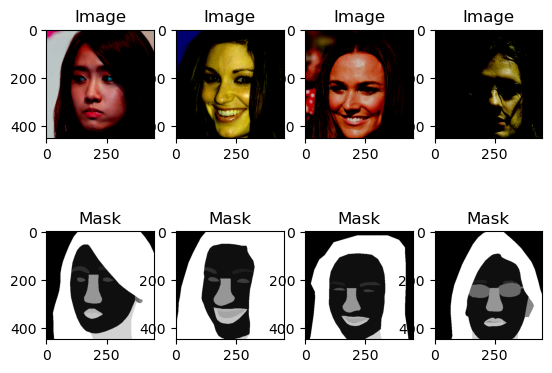

In [8]:
from torch.utils.data import DataLoader

# Define a DataLoader to get batches of samples
dataloader = DataLoader(trainset, batch_size=4, shuffle=True)

# img, mask = next(dataloader)
# Get a batch of samples
for images, masks in dataloader:
    # Visualize each sample in the batch
    print(f'b_img_size: {images.shape}')
    print(f'b_mask_size: {masks.shape}')
    for i in range(images.shape[0]):
        image = images[i].permute(1, 2, 0).numpy()  # Convert PyTorch tensor to NumPy array and rearrange dimensions
        mask = masks[i].numpy()

        # Plot the image and mask side by side
        plt.subplot(2, 4, i + 1)
        plt.imshow(image)
        plt.title('Image')

        plt.subplot(2, 4, i + 5)
        plt.imshow(mask, cmap='gray')  # Assuming masks are grayscale
        # plt.imshow(mask)  # Assuming masks are grayscale
        plt.title('Mask')

    plt.show()
    break  # Only visualize the first batch for simplicity

### DataLoader

In [9]:
batch_size = 6
n_workers = 4

# sampler = torch.utils.data.distributed.DistributedSampler(trainset)

train_loader = DataLoader(trainset,
                    batch_size = batch_size,
                    shuffle = True,
                    # sampler = sampler,
                    num_workers = n_workers,
                    pin_memory = True,
                    drop_last = True)

valid_loader = DataLoader(validset,
                    batch_size = batch_size,
                    shuffle = False,
                    num_workers = n_workers, 
                    pin_memory = True,
                    drop_last = True)

test_loader = DataLoader(testset,
                    batch_size = batch_size,
                    shuffle = False,
                    num_workers = n_workers, 
                    pin_memory = True,
                    drop_last = True)

In [10]:
# diter = iter(train_loader)
# im, lb = next(diter)
# print(im.shape)
# print(lb.shape)
# print(im.dtype)
# print(lb.dtype)
# mask = torch.squeeze(mask, 1)

### Unet

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    # in each stage of downsampling, two convolution layers are applied in a layer
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
            nn.BatchNorm2d(out_channels), 
            nn.ReLU(inplace=True), 
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.double_conv(x)
        return x
    
class DownSample(nn.Module):
    """
        Downsampling after double_conv, then approach next stage of double_conv
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_doubleconv = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        x = self.maxpool_doubleconv(x)
        return x

class UpSample(nn.Module):
    """
        upsample and double_conv
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        # forward
        x1 = self.up(x1)
        
        # Skip Connection
        # input (c, H, W)
        # calculate the dimension difference between downsample feature map
        # and up sample feature map (we want to concat to for skip connection)
        diffX = x2.size()[3] - x1.size()[3]
        diffY = x2.size()[2] - x1.size()[2]
        
        # padding to make the feature map have same size
        # [left, right , top, bottom] side of the tensor
        paddings = [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2]
        x1 = F.pad(x1, paddings)    
        
        # Concatenate along the channel dimension (dimension 1)
        x = torch.cat((x1, x2), dim=1)
        
        # forward
        x = self.double_conv(x)
        
        return x
    
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    
    def forward(self, x):
        x = self.conv(x)
        return x
    
class Unet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(Unet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        
        self.in_conv = DoubleConv(n_channels, 64)
        self.dowsample1 = DownSample(64, 128)
        self.dowsample2 = DownSample(128, 256)
        self.dowsample3 = DownSample(256, 512)
        self.dowsample4 = DownSample(512, 1024)
        
        self.upsample1 = UpSample(1024, 512)
        self.upsample2 = UpSample(512, 256)
        self.upsample3 = UpSample(256, 128)
        self.upsample4 = UpSample(128, 64)
        self.out_conv = OutConv(64, n_classes)
        
    def forward(self, x):
        # Encoder
        x1 = self.in_conv(x)
        x2 = self.dowsample1(x1)
        x3 = self.dowsample2(x2)
        x4 = self.dowsample3(x3)
        x5 = self.dowsample4(x4)
        # Decoder
        x = self.upsample1(x5, x4)
        x = self.upsample2(x, x3)
        x = self.upsample3(x, x2)
        x = self.upsample4(x, x1)
        logits = self.out_conv(x)
        
        return logits

In [12]:
# model = Unet(n_channels=3, n_classes=19)

In [13]:
# batch = torch.randn(1,3,448,448)    
# result = model(batch) #It is your img input
# print(result.shape)

### Loss and metrics

In [14]:
import torch
from torch import Tensor
from criterion import *


def cross_entropy2d(input, target, weight=None, reduction='none'):
    n, c, h, w = input.size()
    nt, ht, wt = target.size()

    # Handle inconsistent size between input and target
    if h != ht or w != wt:
        input = F.interpolate(input, size=(
            ht, wt), mode="bilinear", align_corners=True)

    # https://zhuanlan.zhihu.com/p/76583143
    input = input.transpose(1, 2).transpose(2, 3).contiguous().view(-1, c)
    target = target.view(-1)
    # https://www.cnblogs.com/marsggbo/p/10401215.html
    loss = F.cross_entropy(
        input, target, weight=weight, reduction=reduction, ignore_index=250
    )

    return loss

def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


# def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
#     # Dice loss (objective to minimize) between 0 and 1
#     fn = multiclass_dice_coeff if multiclass else dice_coeff
#     return 1 - fn(input, target, reduce_batch_first=True)

## Training

In [15]:
from torch import optim

In [16]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

from dice import multiclass_dice_coeff, dice_coeff
from metrics import *

class Trainer:
    def __init__(self, model, trainloader, validloader, epochs, criterion, optimizer, scheduler, device, savepath, savename):
        
        self.model = model
        self.train_loader = trainloader
        self.valid_loader = validloader

        self.epochs = epochs
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.savepath = savepath
        self.savename = savename

        if not os.path.exists(self.savepath):
            os.makedirs(self.savepath)

    def train_fn(self):
        self.model.train()
        tr_losses = []
        tr_dice_scores = []

        for img, mask in tqdm(self.train_loader):
            img = img.to(self.device)
            mask = mask.to(self.device)
            # img = img.cuda()
            # mask = mask.cuda()
            
            h, w = mask.size()[1], mask.size()[2]

            # size = mask.size()
            # print(size)
            # mask = mask[:, 0, :, :].view(size[0], 1, size[2], size[3])
            # print(mask.shape)
            # oneHot_size = (size[0], 19, size[2], size[3])
            # mask = torch.cuda.FloatTensor(torch.Size(oneHot_size)).zero_()
            # mask = mask.scatter_(1, mask.data.long().cuda(), 1.0)
            # print(mask.shape)
            # print(mask.min())
            # print(mask.max())

            # 1. clear gradient
            self.optimizer.zero_grad()
            # 2. forward
            pred_mask = self.model(img)
            # mask = F.one_hot(mask, self.model.n_classes)    # (batch, h, w, classes)
            # # mask = mask.permute(0, 3, 1, 2).float()     
            print(mask.shape)
            print(pred_mask.shape)
            # compute the loss
            loss = self.criterion(pred_mask, mask)
            # loss = cross_entropy2d(pred_mask, mask.long(), reduction='mean')
            # back propagation
            loss.backward()
            # parameter update
            self.optimizer.step()

            tr_losses.append(loss.cpu().detach().numpy())

            
            
            # assert mask.min() >= 0 and mask.max() < self.model.n_classes, 'True mask indices should be in [0, n_classes]'
            # convert to one-hot
            # mask = F.one_hot(mask, self.model.n_classes)    # (batch, h, w, classes)
            # mask = mask.permute(0, 3, 1, 2).float()         # (batch, classes, h, w)
            # pred_mask = F.one_hot(pred_mask.argmax(dim=1), self.model.n_classes)
            # print(pred_mask.shape)
            # pred_mask = mask.permute(0, 3, 1, 2).float()
            # print(pred_mask.shape)
            # compute dice score
            # dice_score = multiclass_dice_coeff(pred_mask[:, 1:], mask[:, 1:])
            # tr_dice_scores.append(dice_score)

            avg_tr_loss = sum(tr_losses) / len(tr_losses)
            # avg_dice_score = sum(tr_dice_scores) / len(tr_dice_scores)
            avg_dice_score = 0
        return avg_tr_loss, avg_dice_score
        
    def valid_fn(self):
        self.model.eval()
        val_losses = []
        val_dice_scores = []

        with torch.no_grad():
            for img, mask in tqdm(self.valid_loader):
                img = img.to(self.device)
                mask = mask.to(self.device)
                # img = img.cuda()
                # mask = mask.cuda()

                # size = mask.size()
                # print(size)
                # mask = mask[:, 0, :, :].view(size[0], 1, size[2], size[3])
                # print(mask.shape)
                # oneHot_size = (size[0], 19, size[2], size[3])
                # mask = torch.cuda.FloatTensor(torch.Size(oneHot_size)).zero_()
                # mask = mask.scatter_(1, mask.data.long().cuda(), 1.0)
                # print(mask.shape)
                
                pred_mask = self.model(img)
                loss = self.criterion(pred_mask, mask)
                # loss = cross_entropy2d(pred_mask, mask.long(), reduction='mean')
                val_losses.append(loss.cpu().detach().numpy())

                # assert mask.min() >= 0 and mask.max() < self.model.n_classes, 'True mask indices should be in [0, n_classes]'
                # convert to one-hot
                # mask = F.one_hot(mask, self.model.n_classes)    # (batch, h, w, classes)
                # mask = mask.permute(0, 3, 1, 2).float()         # (batch, classes, h, w)
                # pred_mask = F.one_hot(pred_mask.argmax(dim=1), self.model.n_classes)
                # pred_mask = mask.permute(0, 3, 1, 2).float()
                # compute dice score
                # dice_score = multiclass_dice_coeff(pred_mask[:, 1:], mask[:, 1:])
                # val_dice_scores.append(dice_score)


            avg_val_loss = sum(val_losses) / len(val_losses)
            # avg_dice_score = sum(val_dice_scores) / len(val_dice_scores)
            avg_dice_score = 0
            return avg_val_loss, avg_dice_score
        
    def run(self):
        history = {
        'train_loss' : [],
        'train_dice' : [],
        'valid_loss' : [],
        'valid_dice' : []
        }

        for epoch in range(self.epochs):
            print(f'Epoch {epoch+1:03d} / {self.epochs:03d}:')
            train_loss, train_dice = self.train_fn()
            valid_loss, valid_dice = self.valid_fn()
            self.scheduler.step(valid_dice)

            print('lr:',self.get_lr(self.optimizer))
            print(f'train loss: {train_loss}  valid loss: {valid_loss}')
            print(f'train dice: {train_dice}  valid dice: {valid_dice}')

            history['train_loss'].append(train_loss)
            history['valid_loss'].append(valid_loss)
            history['train_dice'].append(train_dice)
            history['valid_dice'].append(valid_dice)

            # save model if best valid
            if torch.tensor(history['valid_loss']).argmin() == epoch:
                torch.save(self.model.state_dict(), os.path.join(self.savepath, self.savename))
                print('Model Saved!')

        self.plot_save_history(history)


    def get_lr(self, optimizer):
        for param_group in optimizer.param_groups:
            return param_group['lr']
    
    def plot_save_history(self, metrics):
        # Plot the loss curve against epoch
        fig, ax = plt.subplots(2, 1, figsize=(10, 10), dpi=100)
        ax[0].set_title('Loss (L1)')
        ax[0].plot(range(self.epochs), metrics['train_loss'], label='Train')
        ax[0].plot(range(self.epochs), metrics['valid_loss'], label='Valid')
        ax[0].legend()
        ax[1].set_title('MSE')
        ax[1].plot(range(self.epochs), metrics['train_dice'], label='Train')
        ax[1].plot(range(self.epochs), metrics['valid_dice'], label='Valid')
        ax[1].legend()
        plt.show()
        fig.savefig(str(self.savepath / 'metrics.jpg'))
        plt.close()

    


In [17]:
import gc
gc.collect()
torch.cuda.empty_cache()    
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Unet(n_channels=3, n_classes=19).to(DEVICE)
# model = Unet(n_channels=3, n_classes=19).cuda()
# model = nn.DataParallel(model)



In [18]:
EPOCHS = 50
LR = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=LR, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0001, amsgrad=False)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)  # goal: maximize Dice score
criterion = DiceLoss()
# criterion = dice_loss

SAVEPATH = './model_weight/'
SAVENAME = 'model_aug.pth'
DEVICE

device(type='cuda', index=0)

In [19]:

Trainer( model=model, 
        trainloader=train_loader,
        validloader=valid_loader,
        epochs=EPOCHS,
        criterion=criterion, 
        optimizer=optimizer,
        scheduler=scheduler, 
        device=DEVICE,
        savepath=SAVEPATH, 
        savename=SAVENAME).run()

Epoch 001 / 050:


  0%|          | 0/3400 [00:00<?, ?it/s]

torch.Size([6, 448, 448])
torch.Size([6, 19, 448, 448])
torch.Size([22880256])
torch.Size([22880256])


  0%|          | 1/3400 [00:02<2:27:10,  2.60s/it]

torch.Size([6, 448, 448])
torch.Size([6, 19, 448, 448])
torch.Size([22880256])
torch.Size([22880256])


  0%|          | 2/3400 [00:03<1:15:17,  1.33s/it]

torch.Size([6, 448, 448])
torch.Size([6, 19, 448, 448])
torch.Size([22880256])
torch.Size([22880256])


  0%|          | 3/3400 [00:03<52:00,  1.09it/s]  

torch.Size([6, 448, 448])
torch.Size([6, 19, 448, 448])
torch.Size([22880256])
torch.Size([22880256])


  0%|          | 4/3400 [00:03<41:02,  1.38it/s]

torch.Size([6, 448, 448])
torch.Size([6, 19, 448, 448])
torch.Size([22880256])
torch.Size([22880256])


  0%|          | 5/3400 [00:04<34:59,  1.62it/s]

torch.Size([6, 448, 448])
torch.Size([6, 19, 448, 448])
torch.Size([22880256])
torch.Size([22880256])


  0%|          | 6/3400 [00:04<31:20,  1.80it/s]

torch.Size([6, 448, 448])
torch.Size([6, 19, 448, 448])
torch.Size([22880256])
torch.Size([22880256])


  0%|          | 7/3400 [00:05<29:01,  1.95it/s]

torch.Size([6, 448, 448])
torch.Size([6, 19, 448, 448])
torch.Size([22880256])
torch.Size([22880256])


  0%|          | 8/3400 [00:05<27:29,  2.06it/s]

torch.Size([6, 448, 448])
torch.Size([6, 19, 448, 448])
torch.Size([22880256])
torch.Size([22880256])


  0%|          | 8/3400 [00:06<42:59,  1.32it/s]


KeyboardInterrupt: 

### Testing

In [ ]:
testset = CelebAMask_HQ_Dataset(root_dir=root_dir,
                                sample_indices=test_indices,
                                mode='test')

test_loader = DataLoader(testset,
                    batch_size = batch_size,
                    shuffle = False,
                    num_workers = n_workers, 
                    pin_memory = True,
                    drop_last = True)
print(len(testset))

6000


In [ ]:
model = Unet(n_channels=3, n_classes=19).to(DEVICE)
model.load_state_dict(torch.load(os.path.join(SAVEPATH , 'model.pth')))
# model.eval()

<All keys matched successfully>

In [ ]:
class Tester:
    def __init__(self, model,testloader, criterion, device, output_dir):
        
        self.model = model
        self.test_loader = testloader
        self.criterion = criterion
        self.device = device
        self.savepath = output_dir

        if not os.path.exists(self.savepath):
            os.makedirs(self.savepath)

        
    def test_fn(self):
        self.model.eval()
        test_losses = []
        test_dice_scores = []
        cnt = 0

        with torch.no_grad():
            for img, mask in tqdm(self.test_loader):
                img = img.to(self.device)
                # labels = mask.to(self.device)
                mask = mask.to(self.device)
                
                labels = mask
                
                size = labels.size()
                h, w = size[1], size[2]

                pred_mask = self.model(img)
                loss = self.criterion(pred_mask, mask)
                # loss = cross_entropy2d(pred_mask, mask.long(), reduction='mean')
                test_losses.append(loss.cpu().detach().numpy())

                # print(f"pred: {pred_mask.shape}")
                # pred_mask = F.interpolate(pred_mask, (h, w), mode='bilinear', align_corners=True)
                # print(f"pred_interp: {pred_mask.shape}")
                # pred_mask = pred_mask.data.max(1)[1].cpu().numpy()  # Matrix index
                # print(f"pred_fin: {pred_mask.shape}")
                
                # print(f'lb: {labels.shape}')
                # labels = labels[:, :, :].view(size[0], 1, size[1], size[2])
                # print(f'lb_viewed: {labels.shape}')
                # oneHot_size = (size[0], 19, size[1], size[2])
                # labels_real = torch.cuda.FloatTensor(torch.Size(oneHot_size)).zero_()
                # print(f'lb_oh: {labels_real.shape}')
                # labels_real = labels_real.scatter_(1, labels.data.long().cuda(), 1.0)
                # print(f'lb_oh_sc: {labels_real.shape}')

                # print(np.unique(pred_mask.data.max(1)[0].cpu().numpy()))
                pred_mask = pred_mask.data.max(1)[1].cpu().numpy()  # Matrix index
                mask = mask.cpu().detach().numpy()
                img = img.permute(0,2,3,1).cpu().detach().numpy()
                
                
                
                        # color_image[0][mask] = self.cmap[label][0]
                        # color_image[1][mask] = self.cmap[label][1]
                        # color_image[2][mask] = self.cmap[label][2]
                    # print(im.shape)
                    # print(pr_mask.shape)
                    # print(gt_mask.shape)
                    
                    # print(np.unique(pr_mask))
                    # print(np.unique(gt_mask))
                    # print(np.sum(pr_mask == gt_mask))
                    # pass


            avg_test_loss = sum(test_losses) / len(test_losses)
            # avg_dice_score = sum(val_dice_scores) / len(val_dice_scores)
            avg_dice_score = 0
            return avg_test_loss, avg_dice_score
        
    def run(self):
        print(f'Evaluating ... ')
        test_loss, test_dice = self.test_fn()
        print(f'test loss: {test_loss}')




    

In [ ]:
OUTPUT_DIR = "./result"

In [ ]:
Tester(model=model, 
       testloader=test_loader, 
       criterion=criterion, 
       device=DEVICE, 
       output_dir=OUTPUT_DIR).run()

Evaluating ... 


100%|██████████| 1500/1500 [03:23<00:00,  7.38it/s]

test loss: 0.12060271549224853


In [ ]:
cmap = np.array([(0,  0,  0), (204, 0,  0), (76, 153, 0),
                         (204, 204, 0), (51, 51, 255), (204, 0, 204), (0, 255, 255),
                         (51, 255, 255), (102, 51, 0), (255, 0, 0), (102, 204, 0),
                         (255, 255, 0), (0, 0, 153), (0, 0, 204), (255, 51, 153),
                         (0, 204, 204), (0, 51, 0), (255, 153, 51), (0, 204, 0)],
                        dtype=np.uint8)
cnt = 0
for idx in range(len(test_indices)):
    
    for im, pr_mask, gt_mask in zip(img, pred_mask, mask):
        print(pr_mask.shape)
        h, w = pr_mask.shape
        color_pr_mask = np.zeros((h, w, 3))
        color_gt_mask = np.zeros((h, w, 3))
        for label in range(0, len(cmap)):
            p_mask = (label == pr_mask)
            color_pr_mask[p_mask] = cmap[label]
            g_mask = (label == gt_mask)
            color_gt_mask[g_mask] = cmap[label]
        plt.figure(figsize=(12, 12))
        img_list = [im, color_pr_mask, color_gt_mask]
        for i in range(3):
            plt.subplot(1, 3, i+1)
            plt.imshow(img_list[i])
            if cnt < 50:
                plt.show()
                cnt += 1

IndentationError: expected an indented block (3083261486.py, line 8)